## HMM EXAMPLES 

In [1]:
# do all the imports
%matplotlib inline
import sys, os,time
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from pyspch import libhmm 
from pyspch import libhmm_plot as hmmplot
from pyspch import utils as spchu

# print all variable statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# graphical and print preferences
cmap_1 = sns.light_palette("caramel",50,input="xkcd")
cmap_2 = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap_3 = sns.light_palette("caramel",50,input="xkcd")[25:50]
cmap = cmap_2
pd.options.display.float_format = '{:,.3f}'.format

mpl.rcParams['figure.figsize'] = [12.0, 6.0]
#mpl.rcParams['ps.papersize'] = 'A4'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
    column-width: 60px;
    color: black !important;
}

## Generic Class for Discrete Densities

In [178]:
class DiscreteDens():
    '''
    Probability Model for discrete densities for multiple classes, supporting multiple features
    This is very similar to sklearn categoricalNB
    
    Important NOMENCLATURE used throughout:
         - emission probabilities: probabilities in the model
         - observation probabilities: probabilities of the observation stream for the respective states

    Attributes:

        n_classes       int       number of classes
        n_features      int       number of features
        n_categories    array of shape (n_features,) categories for each feature
        classes         array of shape (n_classes,)  known labels for categories
        feature_probs   list of arrays of shape (n_classes,n_categories of feature)
        
    '''
    
    def __init__(self,feature_probs=None,labels=None,classes=None,n_categories=None,n_features=None):
               
        self.n_features = n_features
            
        if feature_probs is None :
            print("ERROR(DiscreteDens): An emission probability matrix is required for initialization")
            exit(1)

        self.feature_probs = feature_probs
        self.n_features = len(self.feature_probs)
        self.n_categories = np.zeros((self.n_features,),'int32')
        self.n_classes = self.feature_probs[0].shape[0]
        for i in range(self.n_features):
            self.n_categories[i] = self.feature_probs[i].shape[1]           
        
        if labels is None:
            self.labels=[]
            for i in range(self.n_features):
                self.labels.append( np.array(['L'+str(i) for i in range(0,self.n_categories[i])]) )
        else:
            self.labels = labels
            
        if classes is None :
            self.classes = np.arange(self.n_classes)
        else:
            self.classes = classes
            
    def lbl2indx(self,Xlabels):
        """
        converts observation labels to array of indices
        
        input and output have shape (n_samples,n_features)
                                 or (n_features,)
        
        """
        return_1D = False
        if Xlabels.ndim ==1 : return_1D = True
        Xlabels = Xlabels.reshape(-1,self.n_features)
        n_samples = Xlabels.shape[0]
        Xindx = np.zeros(Xlabels.shape,'int32')
        for j in range(self.n_features):
            lbls_list = list(self.labels[j])
            for i in range(n_samples):
                Xindx[i,j] = lbls_list.index(Xlabels[i,j])

        if return_1D:
            return(Xindx.flatten())
        else:
            return(Xindx)            
    
    def predict_log_proba(self,X):
        """
        !!! X should be an array of samples (also if single sample)
        !!! always returns a 2D array
        computes state observation likelihoods for discrete desity model
        
        X:  array of shape (n_features,) or (n_samples,n_features)
        returns: array of shape (n_states,) or (n_samples,n_states)
        """
        return spchu.logf(self.predict_proba(X))
            
    def predict_proba(self,X):
        return_1D = False
        if X.ndim == 1: return_1D = True
        X = X.reshape(-1,self.n_features)
        n_samples = X.shape[0]
        proba = np.ones((n_samples,self.n_classes))
        for j in range(self.n_features):
            featprobs = self.feature_probs[j][:,X[:,j]].T
            proba = proba * featprobs
        return proba
        
    def print_model(self,labels=None):
        for j in range(self.n_features):
            print(" ++ Feature (%d) ++"%j)
            labels = self.labels[j]
            
            featprob_df = pd.DataFrame(self.feature_probs[j].T,columns=self.classes,
                     index= ['P('+labels[i]+'|.)' for i in range(0,self.n_categories[j])])
            display(featprob_df)


In [179]:
em1 = np.array([[1.],[2.]])
em2 = np.array([ [0.1,.9], [.2,.8] ])
em3 = np.array([ [0,.6,.4], [.5,.5,0.] ])
fp = [em1,em2]
len(fp), em1.shape, em2.shape
fp[0].ndim
#dd_test = DiscreteDens(feature_probs=fp)

(2, (2, 1), (2, 2))

2

In [180]:
X2=np.array([0])
X2, X2.shape
X3 = X2.reshape(-1,1)
X4 = np.atleast_2d(X2)
X2,X3,X4
X2.shape, X3.shape, X4.shape

(array([0]), (1,))

(array([0]), array([[0]]), array([[0]]))

((1,), (1, 1), (1, 1))

In [181]:
dd_test = DiscreteDens(feature_probs=[em2],labels=[['A','B']])
dd_test.__dict__
dd_test.print_model()
Xl=np.array(['A','B','B','A','B']).reshape(-1,1)
X2=np.array(['A'])
X = dd_test.lbl2indx(X2)
X

dd_test.predict_proba(X)

{'n_features': 1,
 'feature_probs': [array([[0.1, 0.9],
         [0.2, 0.8]])],
 'n_categories': array([2]),
 'n_classes': 2,
 'labels': [['A', 'B']],
 'classes': array([0, 1])}

 ++ Feature (0) ++


,0,1
P(A|.),0.100,0.200
P(B|.),0.900,0.800


array([0])

array([[0.1, 0.2]])

## Single Feature Discrete Density Model

## Example (1) - from the Course Notes

Our HMM example is graphically shown in the drawing below

<img src="hmm_diagram_2.png" width="600">

The HMM parameters consist of **initial probabilities** and **transition probabilities** .
The observation model is captured by a discrete density model parametrized with **emission probabilities**.   
In the notebook we enter these in the matrices **imat**, **tmat** and **emat**.

#### (a) The Observation Model of the HMM

In [185]:
emat = np.array([[.7,.3],[.1, .9],[.6,.4]])
dd1 = DiscreteDens(feature_probs=[emat],labels=[np.array(['A','B'])],classes=np.array(['S0','S1','S2']) )
print("\nDiscrete Density Observation Model\n")
dd1.print_model()


Discrete Density Observation Model

 ++ Feature (0) ++


,S0,S1,S2
P(A|.),0.700,0.100,0.600
P(B|.),0.300,0.900,0.400


#### (b) The state Model of the HMM

In [186]:
imat = np.array([1.0, 0.0, 0.])
tmat = np.array([[.6,.4,0.],[0.,.5,.5],[0.,0.,1.]]) 
hmm1 = libhmm.HMM(n_states=3,prob_style="lin",obs_model=dd1,
                  transmat=tmat,initmat=imat)
hmm1.print_model()

HMM STATE MODEL



,S0,S1,S2
Pinit(S.),1.000,0.000,0.000


,S0,S1,S2
P(S0|S.),0.600,0.000,0.000
P(S1|S.),0.400,0.500,0.000
P(S2|S.),0.000,0.500,1.000


OBSERVATION MODEL

 ++ Feature (0) ++


,S0,S1,S2
P(A|.),0.700,0.100,0.600
P(B|.),0.300,0.900,0.400


#### (c) An Observation Stream
Compute the Observation Probabilities for the Observation Sequence

In [191]:
Xl=np.array(['A','B','B','A','B']).reshape(-1,1)
X = dd1.lbl2indx(Xl)
obs_probs = dd1.predict_proba(X)

print("OBSERVATION LABELS\n")
pd.DataFrame(Xl.T)
print("OBSERVATIONS (INDICES)\n")
pd.DataFrame(X.T) 

print("OBSERVATION PROBABILITIES\n")
pd.DataFrame(obs_probs.T) 

OBSERVATION LABELS



,0,1,2,3,4
0,A,B,B,A,B


OBSERVATIONS (INDICES)



,0,1,2,3,4
0,0,1,1,0,1


OBSERVATION PROBABILITIES



,0,1,2,3,4
0,0.700,0.300,0.300,0.700,0.300
1,0.100,0.900,0.900,0.100,0.900
2,0.600,0.400,0.400,0.600,0.400


## Trellis Computations:
### 1. Forward Pass Probabilities  (Viterbi, Forward Algorithm)

The **TRELLIS** is a matrix structure of shape (n_states,n_samples) containing in *cell (i,t)* the probability of being in *state S_i* at time *t*

(note: strictly speaking in a discrete density model we have observation *probabilities* and in a continuous density model we work with *observation likelihoods*; when talking about the general case we may use the terms probabilities/likelihoods in a loose way)

With *forward pass* we indicate that the Trellis is composed in left-to-right fashion, i.e. a trellis cell contains the probability after having observerd *all observations up to X_t*.  When working with an existing HMM we typically only need a forward pass.
( A *backward pass* (working from last frame till current) is only needed in the forward-backward training algorithm for HMMs. )

It is standard and efficient to fill a Trellis  in a left-to-right *time synchronous* way, i.e. all cells (\*,t) are computed as soon as observation X(t) becomes available and for first order Markov models only knowledge of the current observation and the previous column of the trellis is required.

Hence the trellis computations are simple recursions (coming in 2 flavors):
- **Viterbi Probability** (computes the probability along the most likely path, it is typically used for decoding/recognition and alignment)
$ P(i,t) = \max_j P(j,t-1) * P(j,i) * P(X(t)|i) $   

- **Forward Probability** (computes the "true" probability, is mainly used in training HMMs with the Forward-Backward algorithm)  
$ P(i,t) = \sum_j P(j,t-1) * P(j,i) * P(X(t)|i) $

Note:
- In both cases the sum- or max-operators need to be applied over all possible states that have a transition leading into *State S_i*
- The *state likelihoods* P(X(t)|i) are the likelihood of observing X(t) in State i (also called emmission likelihood)
- We further need some initialization probabilities, that tell us the probability of starting in a State with the first observation, so that we can start the recursion

The left-to-right recursive implementation is illustrated below for the basic example using **Viterbi**:
- the trellis is the main matrix structure
- the annotations above the matrix contain both the label of the observation and the state likelihoods

In [192]:
tr = libhmm.Trellis(hmm1)
tr.viterbi_pass(X.reshape(-1,1))
tr.obs_probs.T, tr.probs.T, tr.backptrs.T

(array([[0.7, 0.3, 0.3, 0.7, 0.3],
        [0.1, 0.9, 0.9, 0.1, 0.9],
        [0.6, 0.4, 0.4, 0.6, 0.4]]),
 array([[0.7       , 0.126     , 0.02268   , 0.0095256 , 0.00171461],
        [0.        , 0.252     , 0.1134    , 0.00567   , 0.00342922],
        [0.        , 0.        , 0.0504    , 0.03402   , 0.013608  ]]),
 array([[ 0,  0,  0,  0,  0],
        [ 1,  0,  1,  1,  0],
        [ 2, -1,  1,  1,  2]]))

### 2. COMPLETION and BACKTRACING

+ a. COMPLETION   
The probability of the full observation being generated by the underlying HMM is found in final column of the Trellis.
We just need to look for the highest scoring cell amongst all states that are admissible ending states.
E.g. in a left-to-right model as the one under consideration we implicitly assume that the we need to end in the final state.

+ b. BACKPOINTERS and BACKTRACKING  
Often we are not only interested in the probability that our observation has for the model, but we may also want to know which states have been traversed (e.g. when we do speech recognition and states are phonemes or words).  In such situation we need to find the state alignment that underlies the best path.  This will only be possible when applying the **Viterbi** algorithm and when maintaining  **backpointers of the full trellis**.  During the forward path computations we add a backpointers in each cell: i.e. we mark the state from which we entered the current state to give us the max probability.   

Finally, when we have completed the Trellis, we can do backtracking from the final state following the backpointers all the way to the initial frame.


In [208]:
print("Key results for Viterbi Pass\n================================")
print("Path Probability: %.4f \nEnd-state: %d" %(tr.end_prob,tr.end_state))
print("Alignment:",tr.backtrace())

Key results for Viterbi Pass
Path Probability: 0.0136 
End-state: 2
Alignment: [0 1 1 2 2]


In [194]:
tr.print_trellis(X=Xl)

Observations



,0,1,2,3,4
X,A,B,B,A,B


Observation Probabilities



,0,1,2,3,4
S0,0.700,0.300,0.300,0.700,0.300
S1,0.100,0.900,0.900,0.100,0.900
S2,0.600,0.400,0.400,0.600,0.400


Trellis Probabilities (Viterbi)



,0,1,2,3,4
S0,0.700,0.126,0.023,0.010,0.002
S1,0.000,0.252,0.113,0.006,0.003
S2,0.000,0.000,0.050,0.034,0.014


Backpointers



,0,1,2,3,4
S0,0,0,0,0,0
S1,1,0,1,1,0
S2,2,-1,1,1,2


Alignment



,0,1,2,3,4
0,0,1,1,2,2


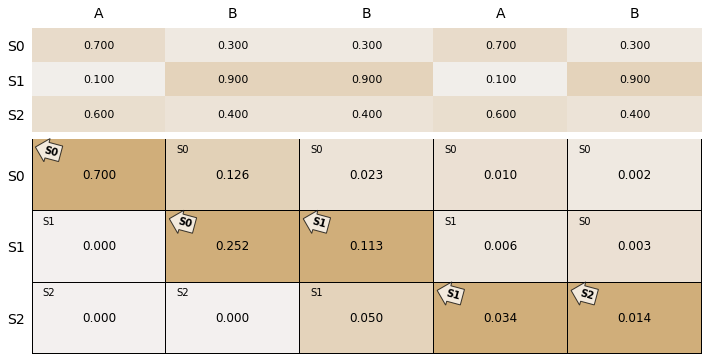

In [195]:
tr.plot_trellis(xticks=Xl.flatten(),plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,cmap=cmap_1,vmin=0.,vmax=2,cmapf=cmap_2)

### 3. Forward Algorithm Example

In [196]:
tr2 = libhmm.Trellis(hmm1,style='Forward')
tr2.forward_pass(X.reshape(-1,1))
tr2.print_trellis()

Observation Probabilities



,0,1,2,3,4
S0,0.700,0.300,0.300,0.700,0.300
S1,0.100,0.900,0.900,0.100,0.900
S2,0.600,0.400,0.400,0.600,0.400


Trellis Probabilities (Forward)



,0,1,2,3,4
S0,0.700,0.126,0.023,0.010,0.002
S1,0.000,0.252,0.159,0.009,0.007
S2,0.000,0.000,0.050,0.078,0.033


## Filling the trellis in a time synchronous way

Observation Probabilities



,0,1,2,3,4
S0,0.700,0.300,0.300,0.700,0.300
S1,0.100,0.900,0.900,0.100,0.900
S2,0.600,0.400,0.400,0.600,0.400


Trellis Probabilities (Viterbi)



,0,1,2,3,4
S0,0.700,0.126,0.023,0.010,0.002
S1,0.000,0.252,0.113,0.006,0.003
S2,0.000,0.000,0.050,0.034,0.014


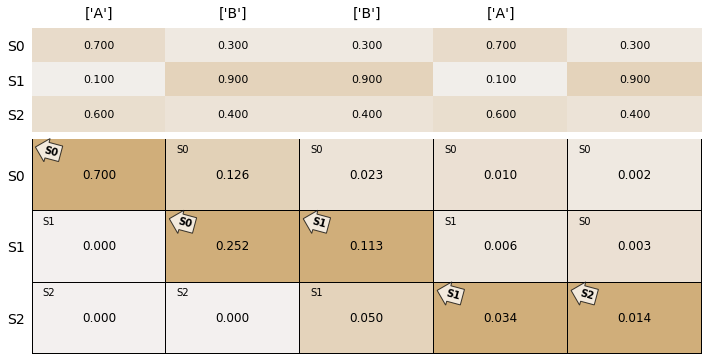

In [197]:
# filling the trellis in a time synchronous way
tr_ = libhmm.Trellis(hmm1)
N = obs_probs.shape[0]
for i in range(N):
    clear_output(wait=True)
    tr_.viterbi_step(X[i])
    tr_.print_trellis(what=['obs_probs','probs'],Titles=True)
    tr_.plot_trellis(xticks=Xl[0:i],plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,cmap=cmap_1,vmin=0.,vmax=2,cmapf=cmap_2)
    time.sleep(2)

## Example 2: Multi-D Discrete Features

In [225]:
em1 = np.array( [ [ .05,.1,.85], [.1,.75,.15], [.5,.3,.2], [.2,.4,.4] ] )
em2 = np.array( [ [.9,.1], [.7,.3], [.1,.9], [.9,.1] ] )
dd2 = DiscreteDens(feature_probs=[em1,em2],
                   labels=[['H','M','L'],['U','V']],
                   classes=[ 'sil', 'm', 'iy', 's'])

dd2.print_model()

 ++ Feature (0) ++


,sil,m,iy,s
P(H|.),0.050,0.100,0.500,0.200
P(M|.),0.100,0.750,0.300,0.400
P(L|.),0.850,0.150,0.200,0.400


 ++ Feature (1) ++


,sil,m,iy,s
P(U|.),0.900,0.700,0.100,0.900
P(V|.),0.100,0.300,0.900,0.100


In [216]:
imat = np.array([1.0, 0.0, 0.0, 0.0])
tmat = np.array([[.5,.5,0.,0.],[0.,.5,.5,0.],[0.,0.,.5,.5],[.5,0.,0.,.5]]) 
hmm2 = libhmm.HMM(n_states=4,prob_style="lin",obs_model=dd2,
                  transmat=tmat,initmat=imat)
hmm2.print_model()

HMM STATE MODEL



,S0,S1,S2,S3
Pinit(S.),1.000,0.000,0.000,0.000


,S0,S1,S2,S3
P(S0|S.),0.500,0.000,0.000,0.500
P(S1|S.),0.500,0.500,0.000,0.000
P(S2|S.),0.000,0.500,0.500,0.000
P(S3|S.),0.000,0.000,0.500,0.500


OBSERVATION MODEL

 ++ Feature (0) ++


,sil,m,iy,s
P(H|.),0.050,0.100,0.500,0.200
P(M|.),0.100,0.750,0.300,0.400
P(L|.),0.850,0.150,0.200,0.400


 ++ Feature (1) ++


,sil,m,iy,s
P(U|.),0.900,0.700,0.100,0.900
P(V|.),0.100,0.300,0.900,0.100


In [219]:
X2l = np.array( [ ['L','U'], ['M','U'], ['L','V'], ['M','U'], ['L','U'] ])
X2 = dd2.lbl2indx(X2l)
X2.T

array([[2, 1, 2, 1, 2],
       [0, 0, 1, 0, 0]])

In [220]:
tr = libhmm.Trellis(hmm2)
tr.viterbi_pass(X2)
tr.obs_probs.T, tr.probs.T, tr.backptrs.T

(array([[0.765, 0.09 , 0.085, 0.09 , 0.765],
        [0.105, 0.525, 0.045, 0.525, 0.105],
        [0.02 , 0.03 , 0.18 , 0.03 , 0.02 ],
        [0.36 , 0.36 , 0.04 , 0.36 , 0.36 ]]),
 array([[7.65000000e-01, 3.44250000e-02, 1.46306250e-03, 6.58378125e-05,
         1.24433466e-03],
        [0.00000000e+00, 2.00812500e-01, 4.51828125e-03, 1.18604883e-03,
         6.22675635e-05],
        [0.00000000e+00, 0.00000000e+00, 1.80731250e-02, 2.71096875e-04,
         1.18604883e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.25316250e-03,
         5.85569250e-04]]),
 array([[ 0,  0,  0,  0,  3],
        [ 1,  0,  1,  1,  1],
        [ 2, -1,  1,  2,  1],
        [ 3, -1, -1,  2,  3]]))

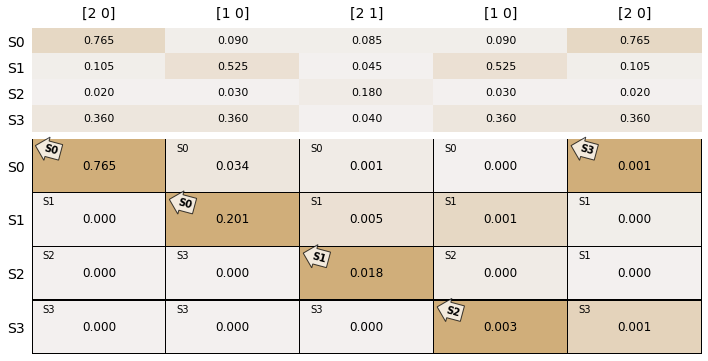

In [224]:
tr.plot_trellis(xticks=X2,plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,cmap=cmap_1,vmin=0.,vmax=2,cmapf=cmap_2)

# CODE BELOW NOT VERIFIED

### All the computation in details
Set Debug True or False for greater levels of detaul

In [198]:
Debug= True
# initialization routine
def init_trellis(hmm,X):
    buf = np.zeros(len(hmm.states))
    state_likelihoods = hmm.observation_prob(X)
    buf = hmm.initmat * state_likelihoods
    return(buf)
# single recursion step
def viterbi_step(hmm,X,buffer):
    newbuf = np.zeros(buffer.shape)
    state_likelihoods = hmm.observation_prob(X)
    print('\nX[t]=',hmm.labels[x],"\nState Likelihoods[.,:]:",state_likelihoods)

    for to_state in range(hmm.n_states):
        if(Debug):
            print("To: %s" %  hmm.states[to_state])
        for from_state in range(hmm.n_states):
            new = hmm.transmat[from_state,to_state] * buffer[from_state]
            if(Debug):
                print("  -- P(%s,t-1) x P(%s|%s): %.3f x %.3f = %.3f" % 
                      (hmm.states[from_state], hmm.states[to_state],hmm.states[from_state],buffer[from_state],hmm.transmat[from_state,to_state], new) )
            if( new > newbuf[to_state] ):
                best_tp = new
                best_state = from_state
        newbuf[to_state] = best_tp * state_likelihoods[to_state]
        if(Debug):
            print("  --> Best Transition is from state %s:  %.3f" % 
                  (hmm.states[best_state], best_tp) )
            #print("  --> Observation Probability in state %s for observation %s : %.3f " % 
            #          (hmm.states[best_state], X, state_likelihoods[to_state]))
            print("  >>> P(%s,t)= %.3f x %.3f = %.3f " % 
                     (hmm.states[to_state], best_tp, state_likelihoods[to_state], newbuf[to_state]))
    return(state_likelihoods,newbuf)  
                
# apply the baseline Viterbi algorithm to our model hmm1 and observation sequence X
buf=init_trellis(hmm1,X[0])
trellis = [buf]
print('INITIALIZATION: X[t]=',hmm1.labels[X[0]],'\n',"Trellis[0,:]:",buf,'\n')
print('RECURSION:')
for x in X[1:]:
    likelihoods, newbuf = viterbi_step(hmm1,x,buf)
    print('Trellis new buffer [t,:]:',newbuf)
    buf = newbuf.copy()
    trellis = np.r_[trellis,[buf]]
    
print("\nFULL TRELLIS")
print(trellis.T)

NameError: name 'hmm1' is not defined

In [ ]:
hmm1.observation_prob

In [ ]:
frameprobs, trellis, backptrs, alignment = hmm1.viterbi_trellis(X)
for i in range(len(X)):
    clear_output(wait=True);
    align = False if (i < len(X)-1) else True
    hmmplot.plot_trellis(hmm1,X[0:i+1],plot_backptrs=True,plot_frameprobs=True,plot_alignment=align,
                         plot_norm=True,cmap=cmap_2,vmin=0,vmax=.5)
    plt.close()
    time.sleep(2)

In [ ]:
# plotting it all once more
empty_line = pd.DataFrame([""]*len(Xl),columns=[""]).T

pd.concat([
    pd.DataFrame(Xl,columns=[""]).T,
    empty_line,
    pd.DataFrame(frameprobs.T,index=hmm1.states),
    empty_line,
    pd.DataFrame(trellis.T,index=hmm1.states),
    empty_line,
    pd.DataFrame(backptrs.T,index=hmm1.states),
    empty_line,
    pd.DataFrame([hmm1.states[i] for i in alignment],columns=[""]).T ]
    ,keys=["OBSERVATIONS",".","LIKELILHOODS","..","TRELLIS","...","BACKPOINTERS","....","ALIGNMENT"] )

In [184]:
class DiscreteDens1():
    '''
    Probability Model for multi-class discrete densities
    
    WARNING: THIS CODE IS SPECIFIC TO SINGLE FEATURE DD

    Important NOMENCLATURE used throughout:
         - emission probabilities: probabilities in the model
         - observation probabilities: probabilities of the observation stream for the respective states

    '''
    
    def __init__(self,emissionmat=None,labels=None,classes=None,n_features=1):
               
        # needs further adjustment for multi-stream input !!
        self.n_features = n_features
        if self.n_features > 1:
            print("only supporting single stream ...")
            exit(1)
            
        if (emissionmat is None) :
            print("ERROR(DiscreteDens): An emission probability matrix is required for initialization")
            exit(1)
        self.emissionmat = emissionmat
        (self.n_classes,self.n_symbols) = self.emissionmat.shape
        
        if labels is None:
            self.labels = np.array(['L'+str(i) for i in range(0,self.n_symbols)])
        else:
            if len(labels) != self.n_symbols:
                print("ERROR(DiscreteDens): e-mat dimemsions don't match with label dimensions")
                exit(-1)
            self.labels = labels

        if classes is None:
            self.classes = np.array(['C'+str(i) for i in range(0,self.n_classes)])
        elif type(classes) == str:
            self.classes = np.array([classes+str(i) for i in range(0,self.n_classes)])
        else:
            self.classes = classes

    def lbl2indx(self,Xlabels):
        """
        converts observation labels to array of indices
        
        !!! for single feature stream
        """
        Xindx = np.array([list(self.labels).index(x) for x in Xlabels])
        return(Xindx.reshape(-1,1))            
    
    def predict_log_proba(self,X):
        """
        !!! X should be an array of samples (also if single sample)
        !!! always returns a 2D array
        computes state observation likelihoods for discrete desity model
        
        X:  array of shape (n_samples,)
        returns: array of shape (n_states,) or (n_samples,n_states)
        """
        return spchu.logf(self.emissionmat[:,X.flatten()].T)
            
    def predict_proba(self,X):
        return self.emissionmat[:,X.flatten()].T
        
    def print_model(self,labels=None):
        if (labels is None):
            symbols = self.labels
        else:
            symbols = labels
            
        edf = pd.DataFrame(self.emissionmat.T,columns=self.classes,
                 index= ['P('+symbols[i]+'|.)' for i in range(0,self.n_symbols)])
        display(edf)


In [ ]:
# 16 JUNE 2021, PM
# An HMM with single state phonemes (TH,IH,S) that can recognize THIS vs. IS
#   - enforced begin silence
#   - optional silence at the end
#
# S0 = Silence;  S1 = "TH"; S2 = "IH"; S3="S" 
# Word 1 = This ( SIL S1 S3 S1 S3 [sil])
# Word 2 = is ( SIL S2 S3 S2 S3 [sil])
# 
hmm = libhmm.DHMM(n_states=4,n_symbols=4,prob_style="prob",states= ['SIL','TH','IH ','S'],labels=['A','B','C','D'])
hmm.init_topology(type='lr',selfprob=0.5)
hmm.transmat = np.array([ [0.6, .2, .2, 0.0], [0., .5, .5, .0 ], [ 0., 0.0, .5, .5 ], [0.15, .0, .0, .85] ])

target_emissionprob = np.array([ [0.70, 0.15, 0.1, 0.05 ], [0.2, 0.45, 0.30, 0.05], 
                                [0.2, 0.2 ,.5, .1], [0.1, .15, .15, .60] ])
hmm.emissionmat = spchu.normalize(target_emissionprob,axis=1)
hmm.end_states= [0,3]
#hmm.set_probstyle("log10")
pd.options.display.float_format = '{:,.2f}'.format
hmm.print_model()

# set an observation sequence
Xl=['A','B','C','B','D','A']
X = [hmm.labels.index(x) for x in Xl]
print("OBSERVATION SEQUENCE\n")
print(Xl)
#print(pd.DataFrame([Xl],index=[""]).to_string(index=False))
#
# plotting a partial trellis
print("\nPARTIAL TRELLIS\n")
pd.options.display.float_format = '{:,.4f}'.format
frameprobs, trellis, backptrs, alignment = hmm.viterbi_trellis(X)
empty_line = pd.DataFrame([""]*len(Xl),columns=[""]).T
trellis[3:6,:] = np.nan
df=pd.DataFrame(trellis,index=Xl,columns=hmm.states).T.fillna("")
display(df)

In [ ]:
# Solution
fig = hmmplot.plot_trellis(hmm,X,cmap=cmap_caramel,vmin=0,vmax=1,fmt=".2e",
        plot_norm=True,
        plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(16,6))
#plt.close()

In [ ]:
# 17 August 2020
#
# State 0 = Silence;  S1 = "P";  S2="M" ; S3 = "AH";
# Word 1 = pa ( SIL S1 S3  [SIL] )
# Word 2 = pap ( SIL S1 S3 S1 [SIL] )
# Word 3 = ma ( SIL S2 S3  [SIL] )
# Word 4 = mam ( SIL S2 S3 S2 [SIL])
# -- papa, mama, 
#
hmm = libhmm.DHMM(n_states=4,n_symbols=5,prob_style="prob",states= ['SIL','P ','M ','AH'],labels=['L1','L2','L3','L4','L5'])
hmm.transmat = np.array([ [0.7, .15, .15, 0.0], 
                          [ 0.05, .4, 0.0, 0.6 ], 
                          [ 0.05, 0.0, 0.5, 0.5 ], 
                          [ 0.2, .1, 0.1, 0.7] ])

target_emissionprob = np.array([ [0.65, 0.07, 0.1, 0.1, 0.02 ], 
                                [0.1, 0.6, 0.1, 0.2, 0.1], 
                                [0.1, 0.2 ,.48,.12, 0.1], 
                                [0.05, .05, .05, .40, .45] ])
hmm.emissionmat = spchu.normalize(target_emissionprob,axis=1)


hmm.set_probstyle("log")
hmm.print_model()
hmm.end_states=[0]

X = [ 0, 1, 1, 4, 3, 1,   0 ]
Xl = [hmm.labels[i] for i in X]
print("OBSERVATION SEQUENCE\n")
print(Xl)

#
# plotting a partial trellis
print("\nPARTIAL TRELLIS\n")
pd.options.display.float_format = '{:,.4f}'.format
frameprobs, trellis, backptrs, alignment = hmm.viterbi_trellis(X)
empty_line = pd.DataFrame([""]*len(Xl),columns=[""]).T
trellis[4:8,:] = np.nan
df=pd.DataFrame(trellis,index=Xl,columns=hmm.states).T.fillna("")
display(df)

fig = hmmplot.plot_trellis(hmm,X,cmap=cmap_caramel,vmin=-4,vmax=0,fmt=".2f",
        plot_norm=True,
        plot_frameprobs=True,plot_backptrs=True,
        plot_alignment=True,figsize=(16,6))
plt.close()
display(fig)
